# DarkCapPy Template

Author: Adam Green

Email : agree019@ucr.edu

This notebook serves to provide a template to calculate the Earth capture scenario. 

In [1]:
import numpy as np
import pandas as pd

from DarkCapPy import *
import DarkCapPy.DarkPhoton as DP
print ('Complete')

Dark Photon Module Imported
Complete


## Import Test

In [4]:
cap1 = DP.photonCCap(mx,ma,epsilon,alpha,alphax)
kappa0 = DP.photonKappa_0(mx,alpha)
cap2 = DP.photonCCapQuick(mx,ma,epsilon,alphax,kappa0)


som = DP.thermAvgSommerfeld(mx,ma,alphax)
sigma = DP.photonSigmaVtree(mx,ma,alphax)
ann = DP.CAnnCalc(mx,sigma,som)

tau = DP.tau(cap1,ann)

gamma = DP.gammaAnn(cap1,ann)
L = DP.decayLength(mx,ma,epsilon,1)
Edecay = DP.epsilonDecay(L)

signal = DP.iceCubeSignal(gamma,Edecay,DP.yr2s(10))


print ('Complete')

Complete


In [5]:
print ('Cap1: ',cap1)
print ('Cap2: ',cap2)

print ('Contour: ', tau/tauCross)
print ('Signal : ', signal)

Cap1:  17393015583359.414
Cap2:  17613272559662.65
Contour:  0.02737054836006153
Signal :  26998236.68491888


# Generate the Sommerfeld File

This section serves to create an external file which contains an arbitrary number of $m_A$ and $\langle S_s \rangle$ points to be interpolated later.

The external file has the following column headers:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0[GeV5]

- Counter serves as an index to loop through
- m_X is specified by the user shortly after the file is created 
- m_A is a list of numbers ranging from $0.01$ GeV to $10$ GeV with arbitrary spacing and density. Since these will each correspond to a $\langle S_s \rangle(m_A)$ to be interpolated later, it is suggested to use logarithmic spacing with a high density $(N\geq2500)$
- ThermAvgSommerfeld is the corresponding $\langle S_s \rangle(m_A)$ point



## Define Point Resolution

This cell defines the resolution of the Sommerfeld enhancement. This number should be large ~2500 because it will be used to create an interpolation later on.

In [7]:
num = 2500

## Initialize Paramter Arrays

We assume the following range for $m_{A'}$:

\begin{equation}
0.01 \ \text{GeV} \leq m_{A'} \leq 10 \ \text{GeV} 
\end{equation}

This will define the range for the mediator mass for the rest of the calculations. 

In [11]:
mALogRange = np.logspace(-2, 1, num, base = 10)
mAArray = []

counter = 0
for mATemp in mALogRange:
                 #( Counter, m_X[GeV], m_A[Gev], ThermAvgSommerfeld, Kappa0[GeV5])
    mAArray.append([counter, ' '     , mATemp  , 'None'            , ' '])
    counter += 1

print ('Complete')

Complete


## Create and Write the DataFrame to a .csv

Filenames should follow the convention:

    <#><Unit>Sommerfeld.csv

including the ".csv" extension.

For example, if $m_X = 100$ GeV,

    100GeVSommerfeld.csv
    
You will also define the value for $m_X$ in this cell

In [14]:
masterSommerfeldDataFrame = \
    pd.DataFrame(mAArray,\
                 columns = \
                 ['Counter','mX[GeV]', 'mA[GeV]', 'ThermAvgSommerfeld', 'Kappa0[GeV5]'])

SommerFile = input('Sommerfeld Filename: ')
writeFile = SommerFile
# writeFile = photonSommerfeldPath(SommerFile)
assert (SommerFile[-4:] == '.csv'), 'File must end with ".csv"'

masterSommerfeldDataFrame.to_csv(writeFile,index=False)

dataFrame = pd.read_csv(writeFile , sep = ',')

m_XValue = float(input('m_X [GeV]: '))
kappa0Value = 'None'

dataFrame.at[0, 'mX[GeV]'] = m_XValue
dataFrame.at[0, 'Kappa0[GeV5]'] = kappa0Value

dataFrame.to_csv(writeFile, index=False)


print ('Complete')

Sommerfeld Filename: testSomm.csv
m_X [GeV]: 100
Complete


## Populating Sommerfeld.csv

In this cell, we:

1). Calculate $\texttt{Kappa0[GeV5]}$

2). Calculate the Sommerfeld enhancement $\langle S_s \rangle$ given each $m_A$ by looping down the list of $m_A$ values 

After each itteration of calculations, the .csv is updated and overwritten, but there is a manual overwrite in the next cell just for good measure

In [3]:
sommerFile = input('Sommerfeld Filename: ')
sommWriteFile = sommerFile
# sommWriteFile = photonSommerfeldPath(sommerFile)

sommDataIn = pd.read_csv(sommWriteFile,sep = ',')

# Define the loop range
looprange = len(sommDataIn['Counter'])

# Read in m_X value
Filem_X = float(sommDataIn.at[0,'mX[GeV]'])
    
##################################
# Calculate Kappa0
##################################
testKappa0 = sommDataIn.at[0,'Kappa0[GeV5]']

if (testKappa0 == 'None'):
    print ('Calculating Kappa0...')
    
    kappa0Value = float(DP.kappa_0(Filem_X, 1./137))
    
    sommDataIn.at[0, 'Kappa0[GeV5]'] = kappa0Value
    sommDataIn.to_csv(sommWriteFile, index=False)
    print('Kappa0 value calculated and set')
    
elif (testKappa0 != 'None'):
    print ('Kappa0 value already calculated')


# sommDataIn.set_value(0, 'Kappa0[GeV5]', kappa0Value)
# sommDataIn.to_csv(sommWriteFile, index=False)    
    
##################################
# Calculate the Sommerfeld enhancements
##################################

finishedCounter = 0
print ('-------------------')
print ('Starting Sommerfeld Calculations...')
for index in range(0,looprange):
    ##################################
    # Initialize Parameters
    ##################################
    m_AValue = sommDataIn.at[index,'mA[GeV]']
    testSomm = sommDataIn.at[index,'ThermAvgSommerfeld']
    
    if (testSomm == 'None'):    
        alpha_X = DP.alphaTherm(Filem_X, m_AValue)
        thermAvgSomm = DP.thermAvgSommerfeld(Filem_X, m_AValue, alpha_X)

        sommDataIn.at[index,'ThermAvgSommerfeld'] = thermAvgSomm
#         sommDataIn.to_csv(sommWriteFile, sep=',', index=False)   
        
        finishedCounter +=1
        if (index%20 == 0):
            print ('Index: {0} recorded'.format(index))
        
    elif(testSomm != 'None'):
        finishedCounter +=1
        
    if (finishedCounter == looprange):
        print ('-------------------')
        print ('All Calculations Complete')
        
    
sommDataIn.to_csv(sommWriteFile, index=False)
print ('Complete')

Sommerfeld Filename: testSomm.csv
Kappa0 value already calculated
-------------------
Starting Sommerfeld Calculations...
Index: 0 recorded
Index: 20 recorded
Index: 40 recorded
Index: 60 recorded
Index: 80 recorded
Index: 100 recorded
Index: 120 recorded
Index: 140 recorded
Index: 160 recorded
Index: 180 recorded
Index: 200 recorded
Index: 220 recorded
Index: 240 recorded
Index: 260 recorded
Index: 280 recorded
Index: 300 recorded
Index: 320 recorded
Index: 340 recorded
Index: 360 recorded
Index: 380 recorded
Index: 400 recorded
Index: 420 recorded
Index: 440 recorded
Index: 460 recorded
Index: 480 recorded
Index: 500 recorded
Index: 520 recorded
Index: 540 recorded
Index: 560 recorded
Index: 580 recorded
Index: 600 recorded
Index: 620 recorded
Index: 640 recorded
Index: 660 recorded
Index: 680 recorded
Index: 700 recorded
Index: 720 recorded
Index: 740 recorded
Index: 760 recorded
Index: 780 recorded
Index: 800 recorded
Index: 820 recorded
Index: 840 recorded
Index: 860 recorded
Inde

### Manual Overwrite

If you interrupt the previous cell, you MUST run this cell. Occassionally, if the interruption occurs during the $\texttt{to_csv}$ command, the external .csv will be blank. However, the dataframe is still stored in Jupyter memory. This cell ensures that the dataframe in Jupyter memory gets written to an external .csv file.

In [5]:
print ('Working Sommerfeld file: {0}'.format(sommWriteFile))

overwrite = input('Overwrite? (y/n): ')
if ((overwrite == 'y') or (overwrite == 'Y')):
    sommDataIn.to_csv(sommWriteFile, index=False)
    print ('Overwrite complete')
    
else:
    print ('Overwrite aborted')


print ('Complete')

Working Sommerfeld file: testSomm.csv
Overwrite? (y/n): n
Overwrite aborted
Complete


# Generating Equilibrium Plots

## Data Input

## Read In Sommerfeld Data and Interpolate

The following cell reads in an external Sommerfeld file and interpolates the discrete set of $\langle S_s (m_A) \rangle$ into a continuous function. This interpolated function is what will be called during the calculation of the equilibrium time instead of calling the Sommerfeld function explicitly. We also determine the correct units of $m_X$ to display once plotted.

In [2]:
from scipy.interpolate import interpolate

sommerfeldFile = input('Sommerfeld Data File: ')
readFile = sommerfeldFile
# readFile = photonSommerfeldPath(sommerfeldFile)

dataIn = pd.read_csv(readFile, sep = ',')

Filem_X = float(dataIn.at[0,'mX[GeV]'])
FileKappa0 = float(dataIn.at[0,'Kappa0[GeV5]'])

###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'

if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'
    

# Double Check to make sure the file name matches the read-in value
print ('Input m_X: {0} GeV'.format(Filem_X))


###############################
# Interpolate Sommerfeld and alpha_X
###############################
maList = dataIn['mA[GeV]']
sommerfeldList = dataIn['ThermAvgSommerfeld']
SommerfeldInterp = interpolate.interp1d(maList, sommerfeldList)


print ('Compete')

Sommerfeld Data File: testSomm.csv
Input m_X: 100.0 GeV
Compete


## Initialize Contour Dictionary

Enter 5 unique contour levels. Note that the contour lines you enter "$\mathrm{L}$" correspond to a contour level of $\frac{\tau}{\tau_{\oplus}} = 10^\mathrm{L}$.

These values are stored as the keys to "$\texttt{contourDictionary}$." By default, the values of this dictionary are an array composed of two sub-arrays. The first sub-array will store the contour lines without Sommerfeld and the second sub-array will store the contour lines with Sommerfeld.

In [3]:
print ('Enter 5 countour lines in ascending or descending order: ')

#contourDictionary = {key: value}
# "key" is the actual contour level
# "value" is an array of plot values: [[],[]] 
# The first one is with sommerfeld off, the second array with sommerfeld on.
         
contourDictionary={}
for i in range(1,6):
    key = (input('Contour Level {0}: '.format(i)))
    type(float(key)) != type(float(0)) # This line ensures that the values entered are numeric
    contourDictionary.update({'{0}'.format(key): [[],[]] } )
    
print ('Complete')

Enter 5 countour lines in ascending or descending order: 
Contour Level 1: -4
Contour Level 2: -2
Contour Level 3: 0
Contour Level 4: 2
Contour Level 5: 4
Complete


## Populate the Contour Dictionary

The following cell populates $\texttt{contourDictionary}$ with the contour values.

In [4]:
for key in contourDictionary:
    contourDictionary[key] = [[],[]]

##################
# Initialize the x-axis
# 0.01 GeV < m_A < 10 GeV
##################
maMin = min(maList)
maMax = max(maList)

maRange = np.logspace(np.log10(maMin), np.log10(maMax), 500, base = 10)

##################
# Populate contourDictionary with plot values
##################
maArray = []

for maTemp in maRange:
    maArray.append(maTemp)

for key in contourDictionary:
    contourline = float(key)
    
    for mATemp in maRange:
        Alpha_X    = DP.alphaTherm(Filem_X, mATemp)
        SigmaVTree = DP.sigmaVtree(Filem_X, mATemp, Alpha_X)
        Sommerfeld = SommerfeldInterp(mATemp)
        CannNoSomm = DP.cAnn(Filem_X, SigmaVTree)
    
        EpsilonNoSomm = DP.contourFunction(mATemp, Alpha_X, CannNoSomm, 1, FileKappa0, contourline)
        EpsilonSomm   = DP.contourFunction(mATemp, Alpha_X, CannNoSomm, Sommerfeld, FileKappa0, contourline)
    
        contourDictionary[key][0].append(EpsilonNoSomm)
        contourDictionary[key][1].append(EpsilonSomm)


print ('Complete')

Complete


## Plot Produciton

The following cell produces a single plot of the equilibrium time. You may choose to turn the Sommerfeld enhancement "on" or "off" by following the prompt.

Sommerfeld on? No:0 Yes:1 1


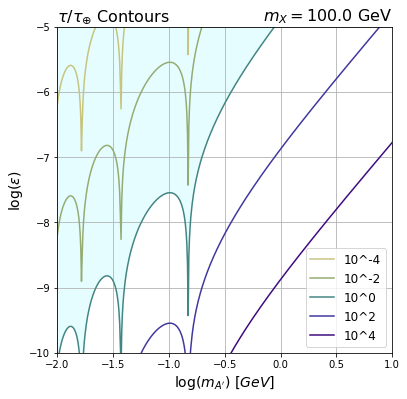

Complete


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
colorScheme1 = mpl.cycler(color=['#c7c47e','#94ab72','#428583','#40379f','#3d0b7e']) 

fig1 = plt.figure(figsize = (6,6))

sommParam = int(input('Sommerfeld on? No:0 Yes:1 '))
assert ((sommParam == 0) or (sommParam == 1)), 'Invalid Input, must be 0 or 1.'


########################################
# This uses a custom color scheme defined in Masterfunctions_Graphing
########################################
colors = colorScheme1
mpl.rcParams['axes.prop_cycle'] = colors

########################################
# Produce the contour lines
########################################
testFill = False
for key in contourDictionary:
    if (float(key) == 0):
        testFill = True
    assert (len(maRange) == len(contourDictionary[key][sommParam])), 'ContourDictionary is probably not populated'
    plt.plot(np.log10(maRange), (contourDictionary[key][sommParam]), label = r'10^{0}'.format(key))
    
    

########################################  
# Shade the valid region of parameter space   
########################################
if (testFill == True):
    xs = np.log10(maArray)
    y1 = contourDictionary['0'][sommParam]
    plt.fill_between(xs, y1, -5, color = '#E6FDFF')

########################################
# Define plot label stuff
########################################
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel(r"$\log(m_{A'})$ $[GeV]$", fontsize = 14)
plt.ylabel(r'$\log(\varepsilon)$', fontsize = 14)

plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),\
          fontsize = 16,\
          loc = 'right')

plt.title(r'$\tau/\tau_{\oplus}$ Contours',\
          fontsize = 16,\
          loc = 'left')
plt.axis([np.log10(min(maRange)),np.log10(max(maRange)),-10,-5])
plt.grid()
plt.show()

print ('Complete')

### Save Figure

In [6]:
filename = input('Figure Name: ')
assert (filename != ''), 'No Filename'
fig1.savefig((filename), dpi = 700)

print ('Complete')

Figure Name: contour1.png
Complete


# Generating IceCube Signal Plots

## Recipie

The recipie for generating the Signal File is:

1). Define the resolution of the signal plot

2). Check this resolution by reading in a Sommerfeld file and Branching Ratio file
 
3). Initialize a template dataframe to hold the calculated signal rate data

3). Write that dataframe to an external .csv file (signalData.csv)

4). Append values from the Sommerfeld and Branching Ratio file to signalData.csv

5). Loop through signalData.csv, calculate $C_{Cap}$, $C_{Ann}$, $\Gamma_{Ann}$, and $N_{Sig}$, append them to signalData.csv

Step five can be quite lengthy depending on the desired resolution of the data points. Typically, one would begin these calculations and be forced to wait until they are completed in their entirety; perhaps unable to shut down their machine for hours at a time. The cell "Signal File Calculations" however can be interrupted at any time, and resumed later. This allows the user to run the calculation in multiple stages instead of dedicating a large chunk of time and running the calculation all at once. 
The calculation can be stopped by interrupting the Jupyter Kernel. Be sure to run the "Manual Overwrite" cell just to be sure that the calculations are saved.

## Define the Resolution of the Signal Plot

These cells create the "grid" of data points for which $N_{\text{sig} }$ will be calculated.

This cell initializes the resolution of the interpolations for the Sommerfeld enhancement and the reach plot. The variable $\texttt{num}$ defines the resolution of the grid, so if $\texttt{num} = 50$, the reach plot will have a $50 \times 50$ resolution for a total of 2500 calculations. The suggested resolution is 

    num = 200
    
A way to understand what this number does: "The cleaner your Sommerfeld interpolation, the cleaner your reach plots will be." Making this number larger will increase the resolution of the interpolation, cleaning up the plots, but it will take longer to calculate. 

A good rule of thumb: Your reach plot resolution will be determined by the resolution of the Sommerfeld Interpolation

In [37]:
# num = 200
num = 200

print ('Complete')

Complete


## External File Interpolations

The following cells read in and create interpolations of the:

1). Sommerfeld Enhancement

2). Branching ratio


The file names for both these files will be written to the signalData.csv file. The reasoning behind this is continuity of the calculation. If you run this notebook from top to bottom, you can calculate everything in one go. However, if you interrup the main calculation cell and restart your computer, all of the vairables we have loaded into Jupyter memroy get wiped. Writing these file names into the signalData.csv file means that to resume the calculation, you only need to run the main calculation cell as opposed to loading variables into Jupyter memory before starting the main calculation

### Sommerfeld Data Interpolation

This interpolation only serves to give you an idea of the resolution of the reach plot. We will read this in and interpolate it again later in the actual calulation. 

Implement some sort of separate plot of the original sommerfeld data so we can compare the interpolated value using num with the original graph

In [18]:
import pandas as pd

####################################
# Define Sommerfeld and Signal Files
####################################
SommFileName = input('Sommerfeld File: ')
SommFile = pd.read_csv(SommFileName)
# SommFile = pd.read_csv(photonSommerfeldPath(SommFileName))

print ('Complete')

Sommerfeld File: testSomm.csv
Complete


### Plot Interpolation vs Original data

Complete


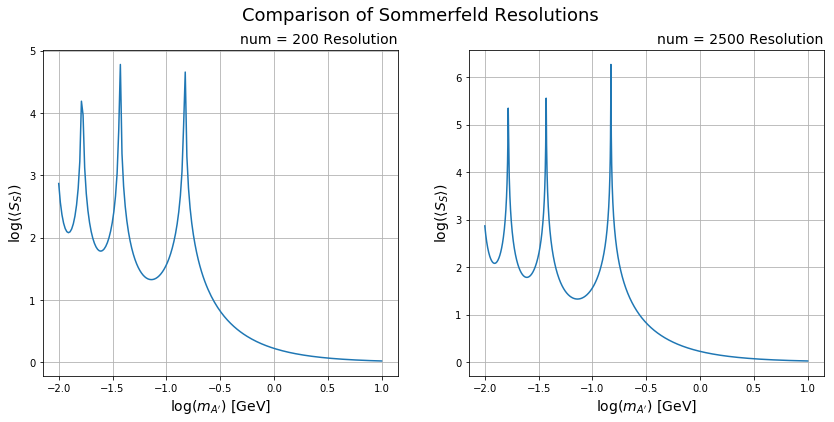

In [38]:
from scipy.interpolate import interpolate
import matplotlib.style
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

%matplotlib inline

####################################
# Interpolate Sommerfeld data
####################################
mAData = SommFile['mA[GeV]']
SommData = SommFile['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData,SommData)

####################################
# Create Comparison Plots
####################################
m_XSommerfeld = SommFile.loc[0,'mX[GeV]']
kappa0Sommerfeld = SommFile.loc[0,'Kappa0[GeV5]']


vect1 = []
vect2 = []
for ma in np.logspace(np.log10(min(mAData)),np.log10(max(mAData)), num, base = 10):
    vect1.append(ma)
    vect2.append(SommInterp(ma))
        
        

fig1 = plt.figure(figsize = (14,6))
plt.suptitle('Comparison of Sommerfeld Resolutions', fontsize = 18)

ax1 = fig1.add_subplot(1,2,1)
ax1.plot(np.log10(vect1),np.log10(vect2))
ax1.set_xlabel(r"$\log(m_{A'})$ [GeV]", fontsize = 14)
ax1.set_ylabel(r"$\log(\langle S_S \rangle)$", fontsize = 14)
ax1.set_title('num = {0} Resolution'.format(num), fontsize = 14, loc = 'right')
plt.grid()

ax2 = fig1.add_subplot(1,2,2)
ax2.plot(np.log10(mAData), np.log10(SommData))
ax2.set_xlabel(r"$\log(m_{A'})$ [GeV]", fontsize = 14)
ax2.set_ylabel(r"$\log(\langle S_S \rangle)$", fontsize = 14)
ax2.set_title('num = 2500 Resolution', fontsize = 14, loc = 'right')
plt.grid()


print ('Complete')

### Branching Ratio Interpolation

In this cell, we read in a .csv file containing discrete branching ratio data points obtained from WebPlotDigitizer and interpolate them into a continuous funciton named $\texttt{branchRatioInterp}$.

By decault, this cell reads in the branching ratio for $\gamma \rightarrow e^+e^-$. To change this, un-comment the first line and comment out the second line.

Branching File: brtoe.csv
Complete


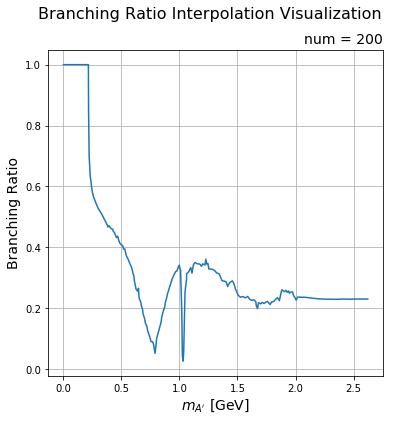

In [39]:
branchFileName = input('Branching File: ')
# branchFileName = 'brtoe.csv'

BranchData = pd.read_csv(('DarkCapPy/'+branchFileName))

xListBranch = BranchData['mA[GeV]']
yListBranch = BranchData['BR']

branchRatioInterp = interpolate.interp1d(xListBranch,yListBranch)


fig = plt.figure(figsize = (6,6))
plt.plot(xListBranch,yListBranch)
plt.xlabel(r"$m_{A'}$ [GeV]", fontsize = 14)
plt.ylabel(r"Branching Ratio", fontsize = 14)
plt.suptitle('Branching Ratio Interpolation Visualization', fontsize = 16)
plt.title('num = {0}'.format(num), fontsize = 14, loc = 'right')
plt.grid()

print ('Complete')

## Initialize Signal Dataframe

This cell:

1) Initializes the signal data frame

2) Appends the $\varepsilon$ and $m_{A'}$ data points based on the resolution dictated by the variable $\texttt{num}$. By default, the range for mediator mass and kinetic mixing are dictated by the range of $m_{A'}$ in the Sommerfld file, and $10^{-11} \leq \varepsilon \leq 10^{-5}$. To change the range of $\varepsilon$, adjust the arguments of the variable ``\texttt{epsilonLogRange}.''

3) Appends the column headers to the data frame

In [40]:
#########################################
# Define parameter space Ranges
#########################################
# Logarithmic Spacing because we plot this in log-log space
# 0.01 GeV < mA < 10 GeV
# 10^-11 < Epsilon < 10^-5

maMin = (min(mAData))
maMax = (max(mAData))

mALogRange = np.logspace(np.log10(maMin), np.log10(maMax), num, base = 10)
epsilonLogRange = np.logspace(-11, -5, num, base = 10)

#########################################
# Initialize Master Arrays
#########################################
masterSignalArray = []

#########################################
# Populate the Master Arrays with the column headers and 'None' Cells
#########################################
counter = 0
for mATemp in mALogRange:
    for epsilonTemp in epsilonLogRange:
        masterSignalArray.append([counter, ' ', mATemp, epsilonTemp, \
                                  'None', 'None', 'None', 'None', \
                                  ' ', ' ',' ', ' '])
        counter +=1
#########################################
# Create a PANDAS DataFrame from the Master Arrays
#########################################
masterSignalDataframe = pd.DataFrame(data = masterSignalArray, \
    columns=['Counter', 'mX[GeV]', 'mA[GeV]', 'Epsilon',\
             'Capture[s-1]', 'Annihilation[s-1]', 'GammaAnn[s-1]', 'IceCubeSignal', \
             'SommerfeldFile', 'BranchingRatioFile','Resolution','Kappa0[GeV5]'])

print ('Complete')

Complete


## Write to External .csv File

This cell writes the signal data frame to an external csv file.

In [41]:
SignalFile = input('Signal Rate filename: ')
writeFile = (SignalFile)
assert (SignalFile[-4:] == '.csv'), 'Must inclue ".csv" in the file name'

#############################
# Double check that these values are correct
#############################
print ('--------------------')
print ('You are about to commit the following to {0}'.format(SignalFile))
print ('mX[GeV]             : {0}'.format(m_XSommerfeld))
print ('Kappa0[GeV5]        : {0}'.format(kappa0Sommerfeld))
print ('Sommerfeld File     : {0}'.format(SommFileName))
print ('Branching Ratio File: {0}'.format(branchFileName))
print ('Resolution          : {0}'.format(num))

print ()

yesNo = input ('Commit to .csv? (y/n)')
assert (yesNo == 'y' or yesNo == 'n'), 'Invalid input, must be "y" or "n."'

if (yesNo == 'y'):

    # Append a single value onto the Kappa0 Column
    kappa0Value = 'None'
    m_XValue = 'None'
    
    masterSignalDataframe.at[0, 'mX[GeV]']            = m_XSommerfeld
    masterSignalDataframe.at[0, 'Kappa0[GeV5]']       = kappa0Sommerfeld
    masterSignalDataframe.at[0, 'SommerfeldFile']     = SommFileName
    masterSignalDataframe.at[0, 'BranchingRatioFile'] = branchFileName
    masterSignalDataframe.at[0, 'Resolution']         = num

    masterSignalDataframe.to_csv(writeFile, index=False)
    
    print ('Commit Executed')
    
else:
    print ('Commit aborted')

print ('Complete')

Signal Rate filename: testSignal.csv
--------------------
You are about to commit the following to testSignal.csv
mX[GeV]             : 100.0
Kappa0[GeV5]        : 5.851659530104901e+27
Sommerfeld File     : testSomm.csv
Branching Ratio File: brtoe.csv
Resolution          : 200

Commit to .csv? (y/n)y


C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Commit Executed
Complete


----------------------

Run these two cells onces you have a working signalData.csv file and you want to either start or resume calculations.

## SignalData.csv Calculations

This cell scans through all the lines of signalData.csv file and calculates:

1). Capture

2). Annihilation

3). GammaAnn

4). Signal

As mentioned previously, this cell may be stopped, by interrupting the kernel, at any time and resumed later.

In [3]:
import pandas as pd
from scipy.interpolate import interpolate
from datetime import datetime
#########################################
# Read in Signal File
#########################################
signalFileName = input('Signal Rate File: ')
signalWriteFile = (signalFileName)
signalDataIn = pd.read_csv(signalWriteFile, sep = ',')

#########################################
# Create backup of Signal File 
#########################################
now = datetime.now()
timeStamp = now.strftime('%b-%d_%H.%M')
signalFileNameCopy = signalFileName[:-4] + '_'+timeStamp+'.csv'
signalDataIn.to_csv((signalFileNameCopy), sep=',', index=False)
print ('Backup Created')


#########################################
# Constants in (mA, epsilon) space:
#########################################
Filem_X = float(signalDataIn.at[0, 'mX[GeV]'])
FileKappa0 = float(signalDataIn.at[0, 'Kappa0[GeV5]'])
Alpha = 1./137
LiveTime = DarkCapPy.Configure.Conversions.yr2s(10)


#########################################
# Sommerfeld Interpolation
#########################################
sommFileName = signalDataIn.at[0,'SommerfeldFile']
# sommDataIn = pd.read_csv(photonSommerfeldPath(sommFileName))
sommDataIn = pd.read_csv(sommFileName)
mAData1 = sommDataIn['mA[GeV]']
SommDataValues = sommDataIn['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData1,SommDataValues)

#########################################
# Branching Ratio Interpolation
#########################################
branchFileName = signalDataIn.at[0,'BranchingRatioFile']
# branchDataIn = pd.read_csv(photonBranchPath(branchFileName))
branchDataIn = pd.read_csv('DarkCapPy/'+branchFileName)


mABranch = branchDataIn['mA[GeV]']
branchingDataValues = branchDataIn['BR']

branchRatioInterp = interpolate.interp1d(mABranch,branchingDataValues)


#########################################
# Begin the loop calculations
#########################################
loopRange = range(0,len(signalDataIn['Counter']))
print ()
print ('--------------------')
finishedCounter = 0
index = 0
for index in loopRange:
    testValue = signalDataIn.loc[index, 'IceCubeSignal']
    
    if (testValue == 'None'):
        #########################################
        # Initialize loop-specific Quantities
        #########################################
        Filem_ATemp = float(signalDataIn.at[index, 'mA[GeV]'])
        FileEpsilonTemp = float(signalDataIn.at[index, 'Epsilon'])
        Alpha_X = DP.alphaTherm(Filem_X, Filem_ATemp)      
        Sommerfeld = SommInterp(Filem_ATemp)
        BranchingRatio = branchRatioInterp(Filem_ATemp)
        
        #########################################
        # Parameter Spce Calculations
        #########################################
        Capture = DP.cCapQuick(Filem_X, Filem_ATemp, FileEpsilonTemp, Alpha_X, FileKappa0)
        SigmaVTree = DP.sigmaVtree(Filem_X, Filem_ATemp, Alpha_X)
        Annihilation = DP.cAnn(Filem_X, SigmaVTree, thermAvgSomm = Sommerfeld)
        GammaAnn = DP.gammaAnn(Capture, Annihilation)
        L = DP.decayLength(Filem_X, Filem_ATemp, FileEpsilonTemp, BranchingRatio)
        EpsilonDecay = DP.epsilonDecay(L)
        
        IceCubeSignal = DP.iceCubeSignal(GammaAnn, EpsilonDecay, LiveTime)

        #########################################
        # Append Calculated Values to SignalFile.csv
        #########################################
        signalDataIn.at[index, 'Capture[s-1]']      = Capture
        signalDataIn.at[index, 'Annihilation[s-1]'] = Annihilation
        signalDataIn.at[index, 'GammaAnn[s-1]']     = GammaAnn
        signalDataIn.at[index, 'IceCubeSignal']     = IceCubeSignal
        
        
        #########################################
        # Overwrite SignalFile.csv
        #########################################
        signalDataIn.to_csv(signalWriteFile, sep=',',index=False) 
        finishedCounter += 1
        
        if (index % 20 == 0):
            print ('Calculations for index: {0} recorded'.format(index))
        
    elif (testValue != 'None'):
        finishedCounter += 1
    
    if (finishedCounter == len(signalDataIn['Counter'])):
        print ('--------------------')
        print ('All Calculations Complete')
        break
        
print ('Complete')

Signal Rate File: testSignal.csv
Backup Created

--------------------
Calculations for index: 0 recorded
Calculations for index: 20 recorded


KeyboardInterrupt: 

## Manual Overwrite

This cell is a manual overwrite of the signalData.csv file.

It is REQUIRED that you run this if you interrupt the calculation. Failure to do so could result in a loss of all your data.

In [4]:
print ('Working Signal File: {0}'.format(signalWriteFile))

overwrite = input('Overwrite? (y/n): ')
if ((overwrite == 'y') or (overwrite == 'Y')):
    signalDataIn.to_csv(signalWriteFile, sep=',',index=False) 
    print ('Overwrite complete')
    
else:
    print ('Overwrite aborted')

print ('Complete')

Working Signal File: testSignal.csv
Overwrite? (y/n): y
Overwrite complete
Complete


## Plot Signal Events

The general recipie is:

1). Read in a Signal Data file

2). Extract the plot information

3). Plot


## Read in External Signal File

In [29]:
signalFile = input('Signal Rate filename: ')
# readFile = photonSignalDataPath_Complete(GammaFile)
readFile = signalFile
testRead = pd.read_csv(readFile) # This is here to ensure that the file exists

print ('Complete')

Signal Rate filename: 100GeVSignal.csv
Complete


## Extract Plot Data

We plot the Data under the column

    mA[GeV], Epsilon, IceCubeSignal

In [30]:
# rawData = pd.read_csv(photonSignalDataPath_Complete(GammaFile))
rawData = pd.read_csv(signalFile)
Filem_X = float(rawData.loc[0,'mX[GeV]'])

#Pull out min / max values on each axis
xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


#########################################
# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
#########################################
gridDim = int(rawData.loc[0,'Resolution'])


#########################################
# Create the n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(np.log10(xMin), np.log10(xMax) , gridDim, base = 10)
yLogRange = np.logspace(np.log10(yMin), np.log10(yMax), gridDim, base = 10)


#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLogRange), len(yLogRange)))

print ('Complete')

Complete


## Plot the Signal Events

C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


Complete


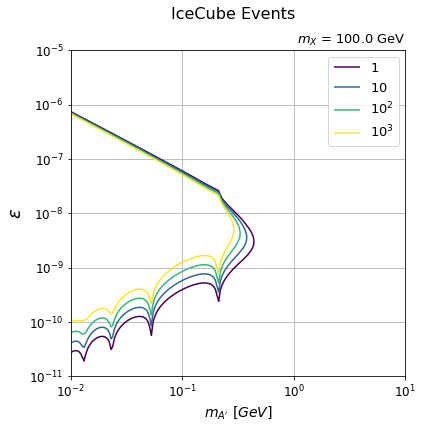

In [31]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Plotting Stuff
###############################
fig0 = plt.figure(figsize = (6,6))

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3],\
                )

xLabelNums = [-2,-1,0,1]
xLabelText = [r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$']

yLabelNums = [-5,-6,-7,-8,-9,-10,-11]
yLabelText = [r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', \
              r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$']


plt.xticks(xLabelNums, xLabelText, fontsize = 12)
plt.yticks(yLabelNums, yLabelText, fontsize = 12)

plt.xlabel(r"$m_{A'}$ $[GeV]$", fontsize = 14)
plt.ylabel(r'$\varepsilon$', fontsize = 18)
plt.suptitle('IceCube Events', fontsize = 16)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)

labels = [r'1', r'$10$',r'$10^2$',r'$10^3$']
for i in range(len(labels)):
    CP.collections[i].set_label(labels[i])

plt.legend(loc='upper right', fontsize = 13)
plt.grid()
print ('Complete')

### Save Figure

In [5]:
figName = input('Filename: ')

fig0.savefig((figName), dpi = 700,
#              bbox_inches = 'tight', \
#              pad_inches= 1\
            )
print ('Complete')

Filename: a


NameError: name 'fig0' is not defined